In [3]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize


import matplotlib
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16)


### a)

In [6]:
df = pd.read_excel("data/sv.xlsx")
df.head()

,GBPUSD
0,-0.355532
1,1.425409
2,-0.443940
3,1.025650
4,1.677579


In [7]:
df['returns'] = df['GBPUSD']/100
print(df['returns'].describe())
df

count    945.000000
mean      -0.000353
std        0.007111
min       -0.032961
25%       -0.004394
50%       -0.000457
75%        0.003644
max        0.045345
Name: returns, dtype: float64


,GBPUSD,returns
0,-0.355532,-0.003555
1,1.425409,0.014254
2,-0.443940,-0.004439
3,1.025650,0.010257
4,1.677579,0.016776
...,...,...
940,0.428767,0.004288
941,-0.093392,-0.000934
942,0.891444,0.008914
943,-0.945963,-0.009460


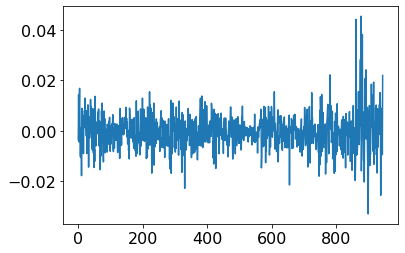

In [8]:
plt.plot(df['returns'])
plt.show()


### b)

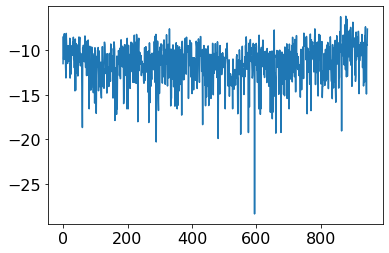

In [9]:
df['xt'] = np.log((df['returns'] - df['returns'].mean())**2)
plt.plot(df['xt'])
plt.show()

In [24]:
df

,GBPUSD,returns,xt
0,-0.355532,-0.003555,-11.487826
1,1.425409,0.014254,-8.452482
2,-0.443940,-0.004439,-11.000233
3,1.025650,0.010257,-9.091992
4,1.677579,0.016776,-8.133977
...,...,...,...
940,0.428767,0.004288,-10.745749
941,-0.093392,-0.000934,-14.902131
942,0.891444,0.008914,-9.362474
943,-0.945963,-0.009460,-9.397527


### c)

In [10]:

# Define the linearized model parameters
phi = 0.995
omega = (1 - phi) * (df['xt'].mean() + 1.27)
s2_eta = (1 - phi) * (np.var(df['xt']) - np.pi**2/2)

# Define the initial state variables and their covariance
a0 = omega / (1 - phi)
P0 = s2_eta / (1 - phi**2)

# Define the observation matrix and covariance
H = np.pi**2/2

# Define the likelihood function
def likelihood(params, a0, P0, y, H):
    omega, phi, s2_eta = params
    n_obs = y.shape[0]
    loglik = 0
    a = a0
    P = P0
    d = -1.27
    c = omega
    T = phi
    Q = s2_eta
    for t in range(n_obs):
        v = y[t] - a - d
        F = P + H
        K = T * P * F**-1

        a = T * a + K * v + c
        P = T**2 * P  + Q -  F * K**2

        # Compute the log-likelihood contribution for this time step
        loglik += -0.5 * (np.log(2 * np.pi) + np.log(F) + v**2 / F)

    return -loglik

params0 = [omega, phi, s2_eta]
bounds = ((None, None), (0, 1), (0, None))
res = minimize(fun=likelihood, x0=params0, args=(a0, P0, df['xt'], H), bounds=bounds, options={'maxiter':5000})
  
omega_hat, phi_hat, s2_eta_hat = res.x


### d)

In [21]:
def kalman_filter(params, y):
    omega, phi, s2_eta = params
    n_obs = y.shape[0]
    a0 = omega / (1 - phi)
    P0 = s2_eta / (1 - phi**2) 
    a = a0
    P = P0
    d = -1.27
    c = omega
    T = phi
    Q = s2_eta
    H = np.pi**2/2

    df_kf = pd.DataFrame(columns=['a_filter', 'P', 'v', 'F', 'K'])

    for t in range(n_obs):
        v = y[t] - a - d
        F = P + H
        K = T * P * F**-1

        df_kf.loc[t] = [a, P, v, F, K]

        a = T * a + K * v + c
        P = T**2 * P  + Q -  F * K**2
      
    uncon_mean = params[0] / (1 - params[1])
    df_kf['h_filter'] = df_kf['a_filter'] - uncon_mean

    return df_kf

df_kf = kalman_filter(res.x, df['xt'])
df_kf

,a_filter,P,v,F,K,h_filter
0,-10.114603,0.375257,-0.103223,5.310059,0.069967,0.000000
1,-10.121825,0.349262,2.939343,5.284064,0.065441,-0.007222
2,-9.929401,0.327147,0.199168,5.261949,0.061555,0.185202
3,-9.918981,0.308160,2.096989,5.242962,0.058192,0.195622
4,-9.798895,0.291732,2.934918,5.226534,0.055263,0.315708
...,...,...,...,...,...,...
940,-9.244280,0.151493,-0.231469,5.086295,0.029489,0.870323
941,-9.259750,0.151493,-4.372381,5.086295,0.029489,0.854853
942,-9.397177,0.151493,1.304703,5.086295,0.029489,0.717426
943,-9.365828,0.151493,1.238302,5.086295,0.029489,0.748775


In [22]:
def kalman_smoother(params, y):
    df_kf = kalman_filter(params, y)
    df_kf = df_kf.iloc[::-1].reset_index(drop=True)
    df_ks = pd.DataFrame(columns=['r', 'a_smoother', 'N', 'V'])
    n_obs = y.shape[0]
    r = 0
    N = 0

    for t in range(n_obs):
        
        r = df_kf['F'][t]**-1 * df_kf['v'][t] + (1-df_kf['K'][t])*r
        N = df_kf['F'][t]**-1 + (1-df_kf['K'][t])**2 * N

        a = df_kf['a_filter'][t] + df_kf['P'][t]*r
        V = df_kf['P'][t] - df_kf['P'][t]**2 * N

        df_ks.loc[t] = [r, a, N, V]

    df_ks = df_ks.iloc[::-1].reset_index(drop=True)
    uncon_mean = params[0] / (1 - params[1])
    df_ks['h_smoother'] = df_ks['a_smoother'] - uncon_mean
    return df_ks    

df_ks = kalman_smoother(res.x, df['xt'])
df_ks


,r,a_smoother,N,V,h_smoother
0,1.813065,-9.434238,2.037513,0.088339,0.680365
1,1.970365,-9.433652,2.137889,0.088474,0.680951
2,1.513119,-9.434389,2.231095,0.088364,0.680214
3,1.572034,-9.434542,2.317586,0.088076,0.680061
4,1.244492,-9.435837,2.397801,0.087661,0.678766
...,...,...,...,...,...
940,0.106712,-9.228114,0.875238,0.131406,0.886489
941,0.156846,-9.235989,0.720498,0.134957,0.878614
942,1.047371,-9.238507,0.556211,0.138728,0.876096
943,0.814888,-9.242379,0.381789,0.142731,0.872224


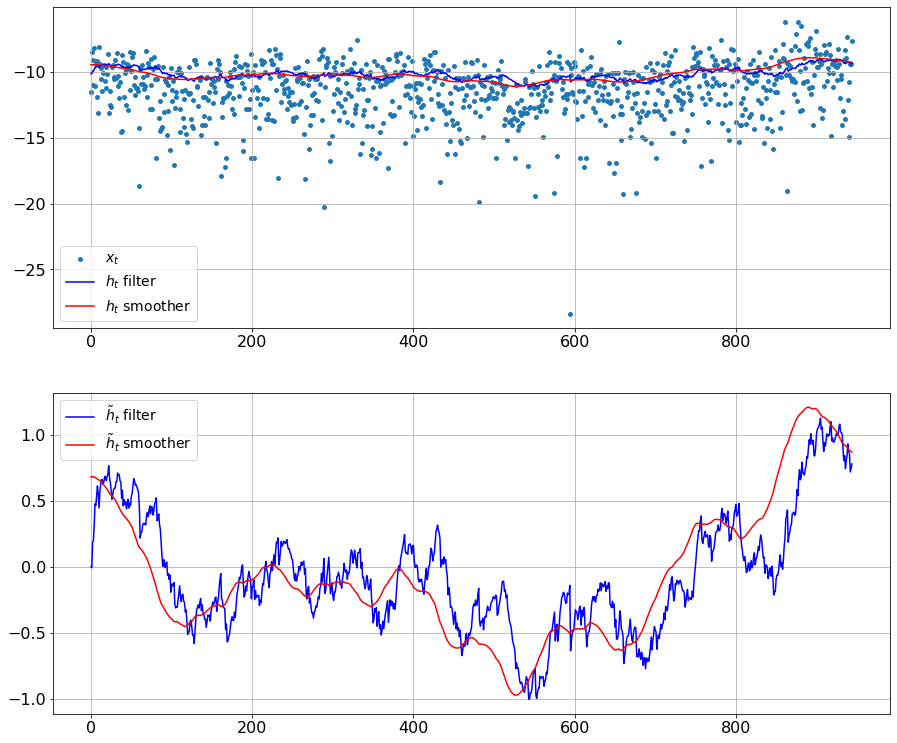

In [9]:
fig, axs = plt.subplots(2,1, figsize=(15,13))

# upper left
ax = axs[0]

ax.scatter(df.index, df.xt, s=15, label = r'$x_t$')
ax.plot(df.index, df_kf.a_filter, color = 'b', label = r'$h_t$ filter')
ax.plot(df.index, df_ks.a_smoother, color = 'r', label = r"$h_t$ smoother")
ax.legend(fontsize = 14)

ax = axs[1]
ax.plot(df.index, df_kf.h_filter, color = 'b', label = r"$\tilde{h}_t$ filter")
ax.plot(df.index, df_ks.h_smoother, color = 'r', label = r"$\tilde{h}_t$ smoother" )
ax.legend(fontsize = 14)

for ax in axs:
    ax.grid()
    pass

plt.show()

### e) (part 1)

In [37]:
tickers = ['^GSPC', 'AAPL']
start_date = '2016-02-09'
end_date = '2021-02-11'

data = yf.download(tickers, start=start_date, end=end_date)

# Extract the adjusted close prices for the tickers
adj_close = data['Adj Close']

# Calculate the daily returns for the tickers
daily_returns = adj_close.pct_change()

df_tick = pd.DataFrame(daily_returns).reset_index()[1:]
df_tick = df_tick.rename(columns={'^GSPC': 'sp'})
df_tick['xt'] = np.log((df_tick.sp - df_tick.sp.mean())**2)
df_tick = df_tick.reset_index(drop=True)
df_tick

[*********************100%***********************]  2 of 2 completed


,Date,AAPL,sp,xt
0,2016-02-10 00:00:00-05:00,-0.007580,-0.000189,-14.129266
1,2016-02-11 00:00:00-05:00,-0.006047,-0.012301,-8.690692
2,2016-02-12 00:00:00-05:00,0.003095,0.019518,-7.942252
3,2016-02-16 00:00:00-05:00,0.028194,0.016517,-8.289071
4,2016-02-17 00:00:00-05:00,0.015315,0.016480,-8.293646
...,...,...,...,...
1255,2021-02-04 00:00:00-05:00,0.025758,0.010853,-9.173195
1256,2021-02-05 00:00:00-05:00,-0.003098,0.003897,-11.469533
1257,2021-02-08 00:00:00-05:00,0.001097,0.007399,-10.001323
1258,2021-02-09 00:00:00-05:00,-0.006574,-0.001114,-12.662977


In [11]:
# Define the linearized model parameters
phi = 0.995
omega = (1 - phi) * (df_tick['xt'].mean() + 1.27)
s2_eta = (1 - phi) * (np.var(df_tick['xt']) - np.pi**2/2)

# Define the initial state variables and their covariance
a0 = omega / (1 - phi)
P0 = s2_eta / (1 - phi**2)

# Define the observation matrix and covariance
H = np.pi**2/2

# Define the likelihood function
def likelihood(params, a0, P0, y, H):
    omega, phi, s2_eta = params
    n_obs = y.shape[0]
    loglik = 0
    a = a0
    P = P0
    d = -1.27
    c = omega
    T = phi
    Q = s2_eta
    for t in range(n_obs):
        v = y[t] - a - d
        F = P + H
        K = T * P * F**-1

        a = T * a + K * v + c
        P = T**2 * P  + Q -  F * K**2

        # Compute the log-likelihood contribution for this time step
        loglik += -0.5 * (np.log(2 * np.pi) + np.log(F) + v**2 / F)

    return -loglik

params0 = [omega, phi, s2_eta]
bounds = ((None, None), (0, 1), (0, None))
res_e = minimize(fun=likelihood, x0=params0, args=(a0, P0, df_tick['xt'], H), bounds=bounds, options={'maxiter':5000})
  
omega_hat, phi_hat, s2_eta_hat = res_e.x

print(res_e.x)


[-0.30014319  0.97019811  0.10528402]


In [12]:
df_kf_1 = kalman_filter(res_e.x, df_tick['xt'])
df_ks = kalman_smoother(res_e.x, df_tick['xt'])

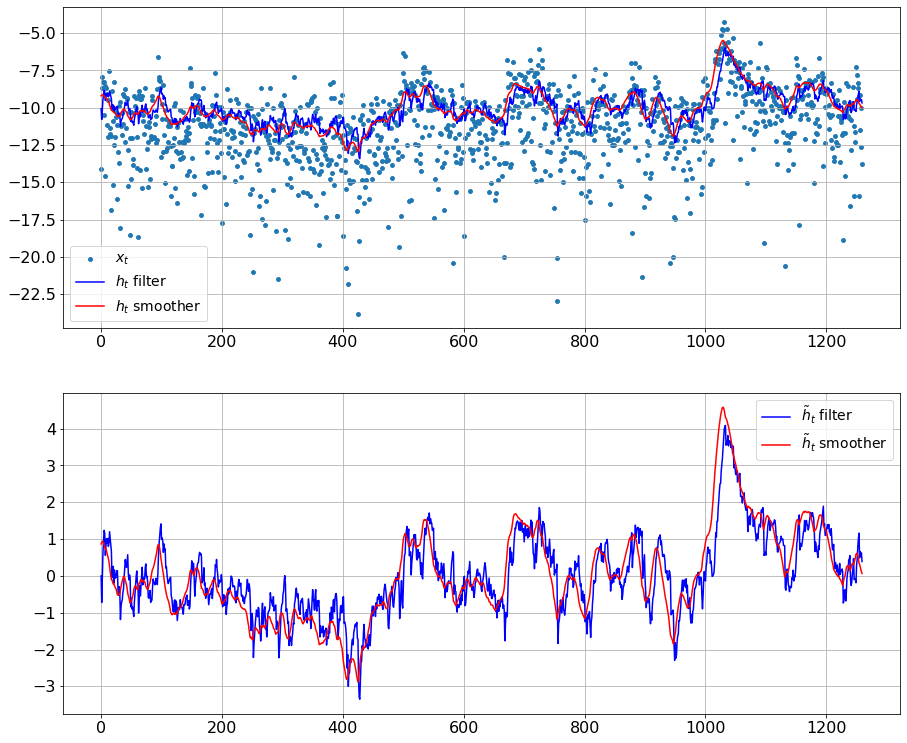

In [13]:
fig, axs = plt.subplots(2,1, figsize=(15,13))

# upper left
ax = axs[0]

ax.scatter(df_tick.index, df_tick.xt, s=15, label = r'$x_t$')
ax.plot(df_tick.index, df_kf_1.a_filter, color = 'b', label = r'$h_t$ filter')
ax.plot(df_tick.index, df_ks.a_smoother, color = 'r', label = r"$h_t$ smoother")
ax.legend(fontsize = 14)

ax = axs[1]
ax.plot(df_tick.index, df_kf_1.h_filter, color = 'b', label = r"$\tilde{h}_t$ filter")
ax.plot(df_tick.index, df_ks.h_smoother, color = 'r', label = r"$\tilde{h}_t$ smoother" )
ax.legend(fontsize = 14)

for ax in axs:
    ax.grid()
    pass

plt.show()

### e) part 2

In [42]:
df_rv = pd.read_csv('data/realized_volatility.csv')
df_rv = df_rv[(df_rv['Symbol'] == '.SPX')].reset_index(drop=True)
df_rv['date'] = pd.to_datetime(df_rv['date'])
df_rv = df_rv[df_rv.date >= pd.to_datetime('2016-02-10 00:00:00+00:00')].reset_index(drop=True)
df_rv = df_rv[['date', 'Symbol', 'rv5']]
df_rv['xt'] = df_tick['xt']
df_rv['rv_adj'] = np.log(df_rv['rv5']) - 1.27
df_kf_1 = kalman_filter(res_e.x, df_rv['xt'])
df_kf_2 = kalman_filter(res_e.x, df_rv['rv_adj'])
beta = (sum(df_kf_2.v * df_kf_1.F**-1  * df_kf_2.v))**-1 * sum(df_kf_2.v * (df_kf_1.F**-1) * df_kf_1.v)
df_rv['xt_adj'] = df_rv['xt'] - beta * np.log(df_rv['rv5'])
df_rv

,date,Symbol,rv5,xt,rv_adj,xt_adj
0,2016-02-10 00:00:00+00:00,.SPX,0.000165,-14.129266,-9.979408,-7.891384
1,2016-02-11 00:00:00+00:00,.SPX,0.000305,-8.690692,-9.365040,-2.892835
2,2016-02-12 00:00:00+00:00,.SPX,0.000097,-7.942252,-10.511011,-1.323623
3,2016-02-16 00:00:00+00:00,.SPX,0.000093,-8.289071,-10.557964,-1.636813
4,2016-02-17 00:00:00+00:00,.SPX,0.000073,-8.293646,-10.788903,-1.475984
...,...,...,...,...,...,...
1245,2021-02-04 00:00:00+00:00,.SPX,0.000020,-15.920105,-12.077224,-8.179717
1246,2021-02-05 00:00:00+00:00,.SPX,0.000023,-11.211605,-11.970449,-3.547691
1247,2021-02-08 00:00:00+00:00,.SPX,0.000022,-11.651913,-11.980094,-3.981092
1248,2021-02-09 00:00:00+00:00,.SPX,0.000009,-12.280215,-12.846193,-3.989074


In [43]:
# Define the linearized model parameters
phi = 0.995
omega = (1 - phi) * (df_rv['xt_adj'].mean() + 1.27)
s2_eta = (1 - phi) * (np.var(df_rv['xt_adj']) - np.pi**2/2)

# Define the initial state variables and their covariance
a0 = omega / (1 - phi)
P0 = s2_eta / (1 - phi**2)

# Define the observation matrix and covariance
H = np.pi**2/2

# Define the likelihood function
def likelihood(params, a0, P0, y, H):
    omega, phi, s2_eta = params
    n_obs = y.shape[0]
    loglik = 0
    a = a0
    P = P0
    d = -1.27
    c = omega
    T = phi
    Q = s2_eta
    for t in range(n_obs):
        v = y[t] - a - d
        F = P + H
        K = T * P * F**-1

        a = T * a + K * v + c
        P = T**2 * P  + Q -  F * K**2

        # Compute the log-likelihood contribution for this time step
        loglik += -0.5 * (np.log(2 * np.pi) + np.log(F) + v**2 / F)

    return -loglik

params0 = [omega, phi, s2_eta]
bounds = ((None, None), (0, 1), (0, None))
res_e2 = minimize(fun=likelihood, x0=params0, args=(a0, P0, df_rv['xt_adj'], H), bounds=bounds, options={'maxiter':5000})
  
omega_hat, phi_hat, s2_eta_hat = res_e2.x
print(res_e2.x)


[-0.04634387  0.98184238  0.01087631]


In [45]:
df_kf3 = kalman_filter(res_e2.x, df_rv['xt_adj'])
df_ks3 = kalman_smoother(res_e2.x, df_rv['xt_adj'])

In [48]:
df_kf3

,a_filter,P,v,F,K,h_filter
0,-2.552309,0.302241,-4.069074,5.237043,0.056664,0.000000
1,-2.782880,0.285426,1.160046,5.220228,0.053684,-0.230571
2,-2.716418,0.270986,2.662794,5.205788,0.051110,-0.164108
3,-2.577344,0.258512,2.210531,5.193315,0.048874,-0.025034
4,-2.468851,0.247681,2.262868,5.182483,0.046924,0.083458
...,...,...,...,...,...,...
1245,-2.559676,0.162859,-4.350041,5.097661,0.031368,-0.007367
1246,-2.695993,0.162859,0.418301,5.097661,0.031368,-0.143684
1247,-2.680263,0.162859,-0.030830,5.097661,0.031368,-0.127953
1248,-2.678906,0.162859,-0.040167,5.097661,0.031368,-0.126597


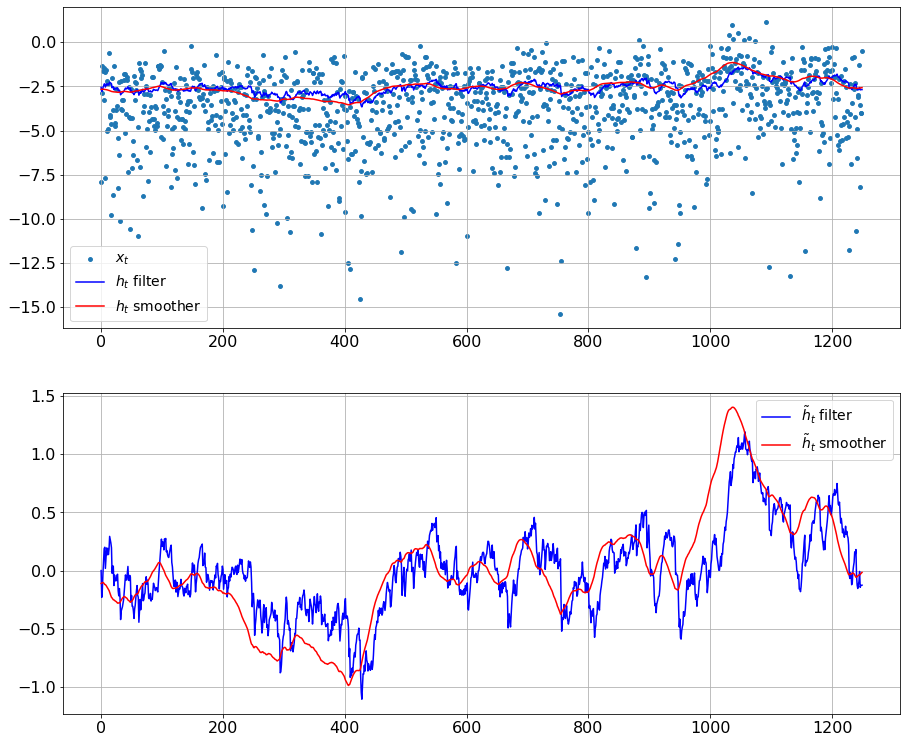

In [49]:
fig, axs = plt.subplots(2,1, figsize=(15,13))

# upper left
ax = axs[0]

ax.scatter(df_rv.index, df_rv.xt_adj, s=15, label = r'$x_t$')
ax.plot(df_kf3.index, df_kf3.a_filter, color = 'b', label = r'$h_t$ filter')
ax.plot(df_kf3.index, df_ks3.a_smoother, color = 'r', label = r"$h_t$ smoother")
ax.legend(fontsize = 14)

ax = axs[1]
ax.plot(df_kf3.index, df_kf3.h_filter, color = 'b', label = r"$\tilde{h}_t$ filter")
ax.plot(df_kf3.index, df_ks3.h_smoother, color = 'r', label = r"$\tilde{h}_t$ smoother" )
ax.legend(fontsize = 14)

for ax in axs:
    ax.grid()
    pass

plt.show()

### f)

In [19]:
def bootstrap_filter(params, N, y, k):

    omega, phi, s2_eta = params
    n_obs = y.shape[0]
    weight_t = np.array([1 for i in range(N)])
    s2 = s2_eta / (1-phi**2)

    df_bs = pd.DataFrame(columns=['a_bootstrap'])

    for t in range(n_obs):
        #step 1
        if t == 0:
            alpha_t = np.random.randn(N) * s2**0.5
        else:
            alpha_t = np.random.randn(N) * s2**0.5 + phi*alpha_t
        #step 2
        # weight_t = weight_t*np.exp((-0.5*np.log(2* np.pi) - 0.5*np.log(s2_eps) - 0.5*s2**-2*(y[t] - alpha_t)))
        weight_t = np.exp(-0.5*(np.log(2*np.pi) + alpha_t + np.exp(-1 * alpha_t)*(y[t]-y.mean())**2))
        weight_t /= sum(weight_t)
        #step 3
        a_t = np.dot(weight_t,alpha_t)
        #step 4
        if sum(weight_t**2)**-1 < k*N:
            alpha_t = np.random.choice(alpha_t, replace=True, p=weight_t)

        df_bs.loc[t] = [a_t]

    return df_bs

df_bs = bootstrap_filter(params=res.x, N=10000, y=df['returns'], k=0.75)
df_bs 


,a_bootstrap
0,-0.190335
1,-0.370421
2,-0.554138
3,-0.739806
4,-2.681131
...,...
940,-5.760293
941,-5.887886
942,-5.985665
943,-6.088778


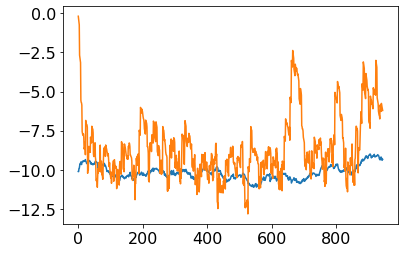

In [23]:
plt.plot(df_kf.a_filter)
plt.plot(df_bs.a_bootstrap)